# Portfolio Analysis and Optimization

Created as an ongoing project which will be extended. Serves mainly as a practice of implementing financial portfolio theories.

In [21]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import quandl
import matplotlib.pyplot as plt
import scipy.stats as stats 
import scipy.optimize as opt
import pylab
from pandas_datareader import data as pdr

In [116]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

## Get all available securities from Yahoo Finance

In [57]:
NUM_TRAD_DAYS = 252

class Portfolio():
    """
    """
    def __init__(self, asset_list, market, start, end, rf_rate=0):
        #self.asset_list = asset_list
        #self.market = self.market
        self.rf_rate = rf_rate
        #self.time = (start, end)
        self.N        = len(asset_list)
        
        market        = pdr.DataReader(market, 'yahoo', start, end)
        asset_prices  = pdr.DataReader(asset_list, 'yahoo', start, end)
        
        asset_prices  = asset_prices['Adj Close'].dropna()
        asset_returns = asset_prices.pct_change().dropna()
        asset_log_returns = np.log(asset_prices/asset_prices.shift(1)).dropna()
        
        asset_summary = pd.DataFrame()
        
        ### Kolmogorov Smirnov (KS) Test
        KS_test = []
        for asset in asset_list:
            ks_stat, p = stats.kstest(asset_log_returns.loc[:,asset], 'norm')
            #print(ks_stat, p_value)
            if p > 0.05:
                KS_test.append('Gaussian')
            else:
                KS_test.append('Not Gaussian')
                
        
        asset_summary["mean"]         = asset_log_returns.mean()
        asset_summary["daily_SD"]     = asset_log_returns.std()
        asset_summary["annual_SD"]    = asset_summary["daily_SD"] * np.sqrt(NUM_TRAD_DAYS)
        asset_summary["Sharpe_ratio"] = (asset_summary["mean"] - rf_rate) * NUM_TRAD_DAYS / asset_summary["annual_SD"]
        asset_summary["KS_Test"]      = KS_test
        
        self.asset_prices      = asset_prices
        self.asset_returns     = asset_returns
        self.asset_log_returns = asset_log_returns
        self.asset_covMat      = asset_returns.cov()
        self.asset_summary     = asset_summary
        
    def portfolio_performance(self, weights):
        """return the portfolio return and SD given some weights
        portfolio variance = 1/2 w^T \sum w
        """
        returns = np.sum(self.asset_returns.mean() * weights) * NUM_TRAD_DAYS
        SD = np.sqrt(np.dot(weights.T, np.dot(self.asset_covMat, weights))) * np.sqrt(NUM_TRAD_DAYS)
        return returns, SD
    
    def portfolio_variance(self, weights):
        return self.portfolio_performance(weights)[1]
    
    def obj_fkt_weights(self, weights):
        """objective function for the optimization of portfolio weights"""
        returns, sd = self.portfolio_performance(weights)
        return -(returns - rf_rate) / sd
    
    def get_optimal_weights(self):
        """maximize sharp ratio using scipy's SLSQP minimization method"""
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0,1) for _ in range(self.N))
        results = opt.minimize(self.obj_fkt_weights, self.N*[1./self.N],
                               method='SLSQP', bounds=bounds, constraints=constraints)
        return results['x'], -results['fun']
    
    def get_min_variance(self):
        """minimize portfolio variance given the weights"""
        
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0,1) for _ in range(self.N))
        results = opt.minimize(self.portfolio_variance, self.N*[1./self.N],
                               method='SLSQP', bounds=bounds, constraints=constraints)
        return results['x'], results['fun']
        
    def plot_prices(self):    
        self.asset_prices.plot(figsize=(10,7))
        
    def plot_returns(self):
        fig, ax = plt.subplots(4,2, figsize=(12,15))
        bins = 150
        self.asset_log_returns.iloc[:,0].plot.hist(bins=bins, ax=ax[0,0])
        stats.probplot(self.asset_log_returns.iloc[:,0], dist='norm', plot=ax[0,1])
        self.asset_log_returns.iloc[:,1].plot.hist(bins=bins, ax=ax[1,0])
        stats.probplot(self.asset_log_returns.iloc[:,1], dist='norm', plot=ax[1,1])
        self.asset_log_returns.iloc[:,2].plot.hist(bins=bins, ax=ax[2,0])
        stats.probplot(self.asset_log_returns.iloc[:,2], dist='norm', plot=ax[2,1])
        self.asset_log_returns.iloc[:,3].plot.hist(bins=bins, ax=ax[3,0])
        stats.probplot(self.asset_log_returns.iloc[:,3], dist='norm', plot=ax[3,1])
        ax[0,0].set_title(str(self.asset_prices.keys()[0]))
        ax[1,0].set_title(str(self.asset_prices.keys()[1]))
        ax[2,0].set_title(str(self.asset_prices.keys()[2]))
        ax[3,0].set_title(str(self.asset_prices.keys()[3]))
        fig.tight_layout()
        plt.setp(ax[:,0], xlim=(-0.2,0.2))
        plt.show()
        
    def plot_rolling_stats(self, days):
        # rolling time window
        return_vol = self.asset_log_returns.rolling(window=days).std() * np.sqrt(days)
        sharpe_ratio = (self.asset_log_returns.rolling(window=days).mean() - rf_rate) * days / return_vol
        
        sharpe_ratio.plot(figsize=(12,8), title="Sharpe Ratio - Rolling Window of %i days" % days) #.update_layout(autosize=False, width=1000, height=500)
        return_vol.plot(figsize=(12,8), title="SD - Rolling Window of %i days" % days) #.update_layout(autosize=False, width=600, height=350)
        #plt.show()
        

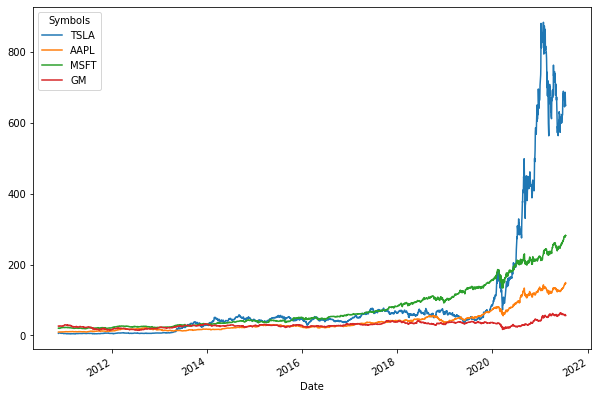

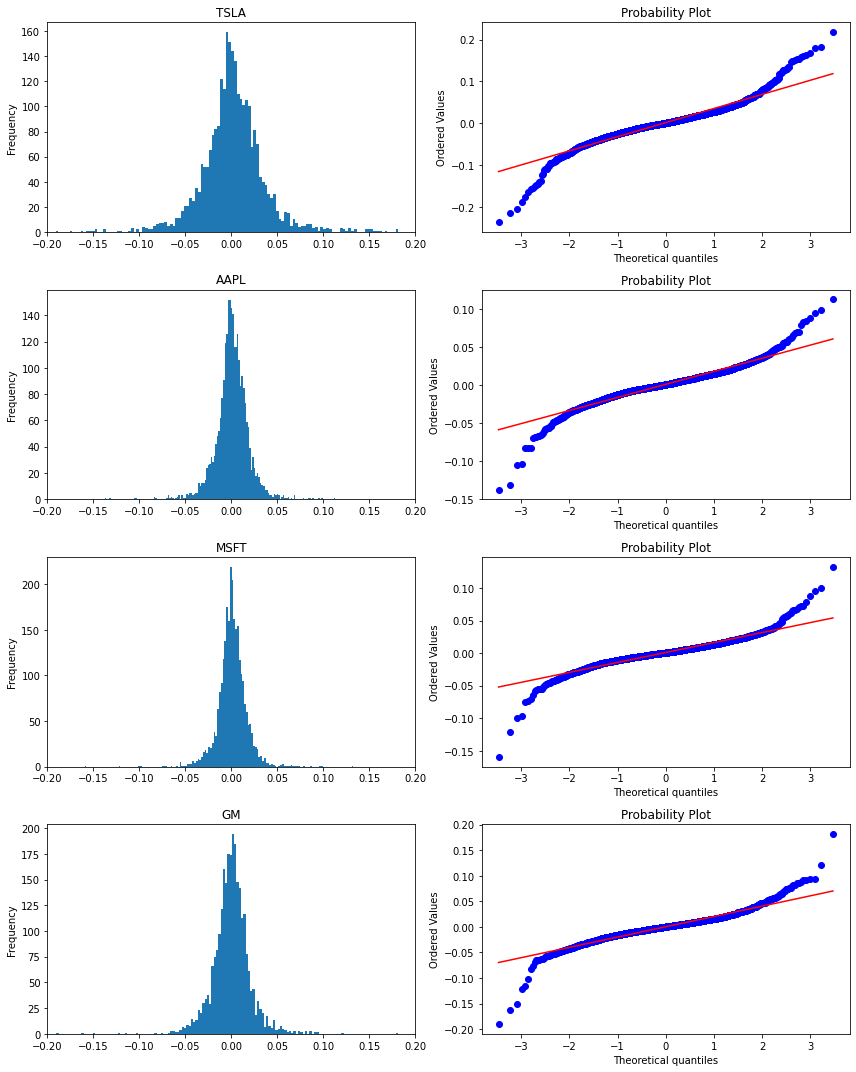

max sharp ratio:  (array([2.40216390e-01, 3.33081684e-01, 4.26701926e-01, 2.44804588e-17]), 1.3842061600822035)
min variance:  (array([0.00355347, 0.29953218, 0.47501284, 0.22190151]), 0.224516630232885)


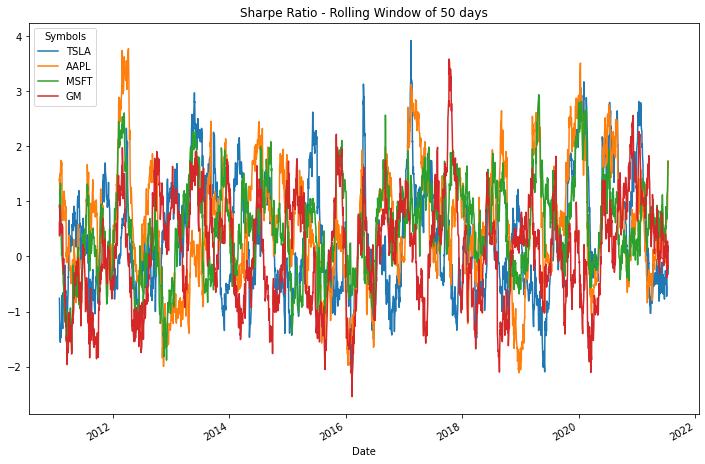

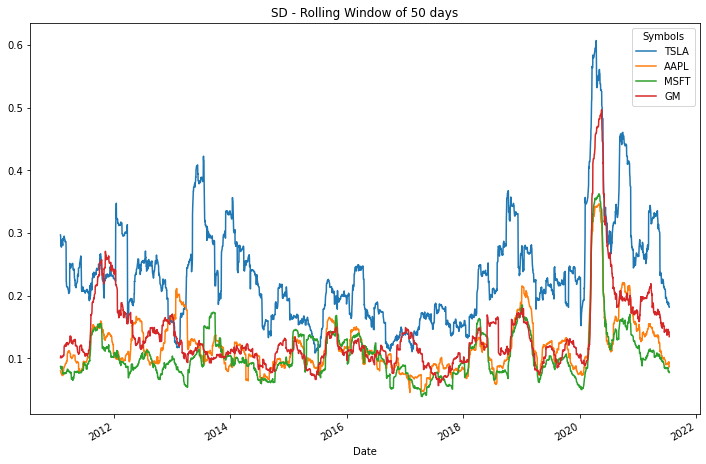

In [58]:
#gold = 'GC=F'

market = '^GSPC'
asset_list = ['TSLA', 'AAPL', 'MSFT', 'GM']  # Gold, Tesla, Apple, Crude Oil, S&P 500, 
start, end = dt.datetime(2010,1,1), dt.datetime.now()
rf_rate = 0.01 / NUM_TRAD_DAYS # daily risk free rate

portfolio = Portfolio(asset_list, market, start, end, rf_rate)
portfolio.plot_prices()
portfolio.plot_returns()
days=50
portfolio.plot_rolling_stats(days)
portfolio.asset_summary
print("max sharp ratio: ", portfolio.get_optimal_weights())
print("min variance: ", portfolio.get_min_variance())

<AxesSubplot:xlabel='Date'>

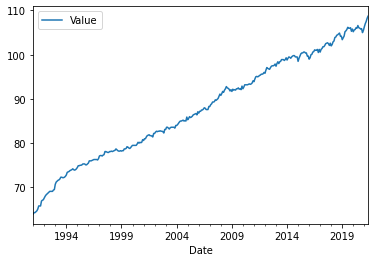

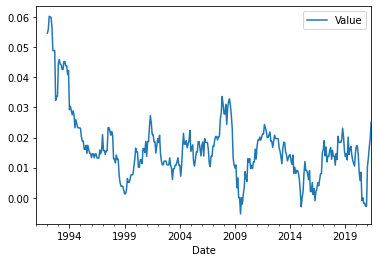

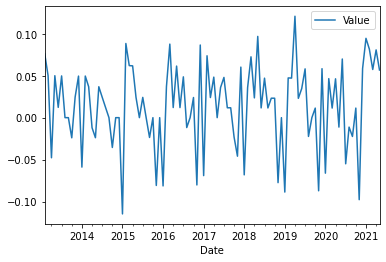

In [108]:
keys = pd.read_csv(os.getcwd()+"\Documents\Python Projects\API_Keys.csv", index_col="API")
quandl.ApiConfig.api_key = keys.loc["quandl"][0]
mydata = quandl.get("RATEINF/CPI_DEU")
mydata[-1000:].plot()
(np.log(mydata/mydata.shift(12))).plot() #12months inflation rate
(((np.log(mydata/mydata.shift(1))+1)**12)-1)[-100:].plot() #monthly inflation rate (expressed as annual)